In [1]:
from google.colab import drive
import os

# Mount Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import matplotlib.pyplot as plt
import os
import torch
import numpy as np
from tqdm import tqdm
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from torchvision.transforms import ToTensor
from torchsummary import summary

In [3]:
import re

def sorted_alphanumeric(data):

    convert = lambda text: int(text) if text.isdigit() else text.lower()
    alphanum_key = lambda key: [convert(c) for c in re.split('([0-9]+)', key)]
    return sorted(data, key=alphanum_key)

In [4]:
class ImageDataset(Dataset):
    def __init__(self, low_path, high_path, size = 256):
        self.size = size
        self.low_path = low_path
        self.high_path = high_path
        self.high_files = sorted_alphanumeric(os.listdir(high_path))
        self.low_files = sorted_alphanumeric(os.listdir(low_path))

    def __len__(self):
        return len(self.low_files)


    def __getitem__(self, idx):

        high_img_path = os.path.join(self.high_path, self.high_files[idx])
        low_img_path = os.path.join(self.low_path, self.low_files[idx])

        high_img = cv2.imread(high_img_path, 1)
        high_img = cv2.cvtColor(high_img, cv2.COLOR_BGR2RGB)
        high_img = cv2.resize(high_img, (self.size, self.size))
        high_img = high_img.astype('float32') / 255.0

        low_img = cv2.imread(low_img_path, 1)
        low_img = cv2.cvtColor(low_img, cv2.COLOR_BGR2RGB)
        low_img = cv2.resize(low_img, (self.size//4, self.size//4))
        low_img = low_img.astype('float32') / 255.0

        return {
            'high_img': ToTensor()(high_img),
            'low_img': ToTensor()(low_img)
        }

In [5]:
high_res_path = '/content/drive/MyDrive/Lab02/Data/Train set/high_res'
low_res_path = '/content/drive/My Drive/Lab02/Data/Train set/low_res'
test_high_res_path = '/content/drive/My Drive/Lab02/Data/Test set/high_res'
test_low_res_path = '/content/drive/My Drive/Lab02/Data/Test set/low_res'

# Create dataset instance
dataset = ImageDataset(low_res_path, high_res_path)
test_set = ImageDataset(test_low_res_path, test_high_res_path)

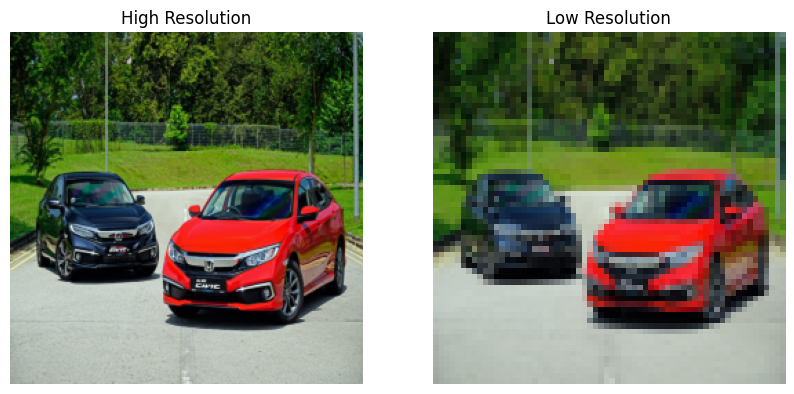

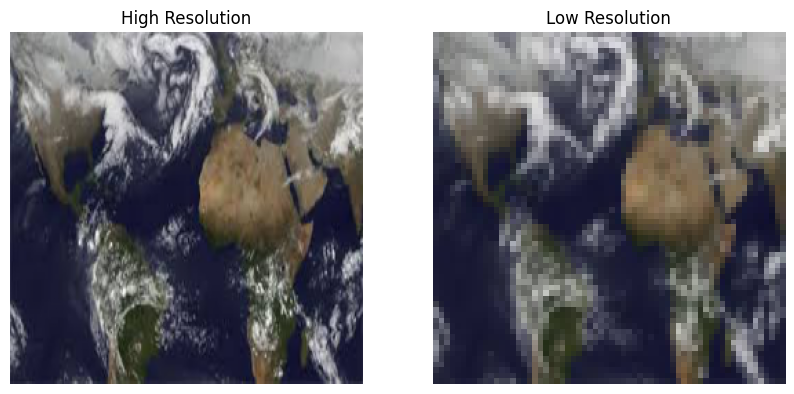

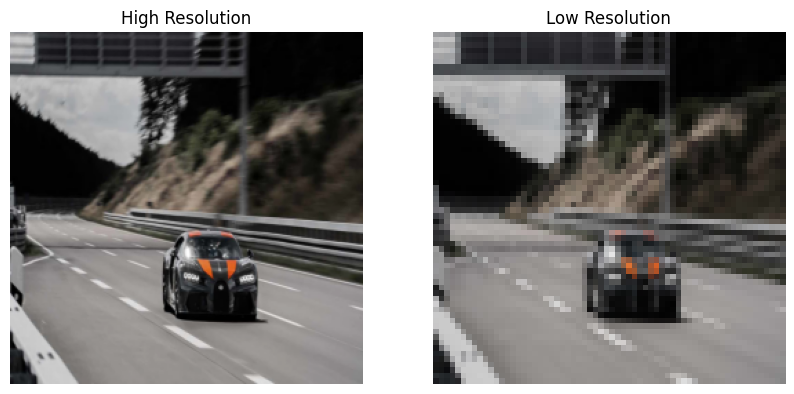

In [6]:
import matplotlib.pyplot as plt
import cv2
num_pairs_to_print = 3

for idx in range(num_pairs_to_print):
    sample = dataset[idx]
    high_img, low_img = sample['high_img'], sample['low_img']
    #Convert the pytorch tensors to numpy arrays
    #Matplotlib expects the images to be in the format : height, width, channels whereas the the pytroch tensor has it in the form of channels, height, width
    #After doing this we convert to the numpy array
    high_img_np = high_img.permute(1, 2, 0).numpy() if high_img.shape[0] == 3 else high_img.numpy()
    low_img_np = low_img.permute(1, 2, 0).numpy() if low_img.shape[0] == 3 else low_img.numpy()

    # Plot high-resolution and low-resolution images
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(high_img_np)
    plt.title('High Resolution')
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(low_img_np)
    plt.title('Low Resolution')
    plt.axis('off')

    plt.show()


In [7]:
from torch.utils.data import random_split

print("Number of high-resolution images:", len(dataset.high_files))
print("Number of low-resolution images:", len(dataset.low_files))
print("Number of Test high-resolution images:", len(test_set.high_files))
print("Number of Test low-resolution images:", len(test_set.low_files))

train_size = int(0.8 * len(dataset))
val_size = int(0.2 * len(dataset))
# Split the dataset into train, validation sets
train_set, val_set = random_split(dataset, [train_size, val_size])
print("Length of training set is: ", len(train_set))
print("Length of validation set is: ", len(val_set))
print("Length of testing set is: ", len(test_set))


Number of high-resolution images: 360
Number of low-resolution images: 360
Number of Test high-resolution images: 40
Number of Test low-resolution images: 40
Length of training set is:  288
Length of validation set is:  72
Length of testing set is:  40


In [8]:
batch_size = 8
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False)

MODEL

In [9]:
# using gpu if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.models as models

#build your model here
######################################SRResNet###########################
# Define the basic block used in SRResNet: Residual Block



class ResidualBlock(nn.Module):
    def __init__(self, in_channels):
        super(ResidualBlock, self).__init__()
        self.block = nn.Sequential(
            nn.Conv2d(in_channels, in_channels, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(in_channels),
            nn.PReLU(),
            nn.Conv2d(in_channels, in_channels, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(in_channels)
        )

    def forward(self, x):
        return x + self.block(x)  


class Generator(nn.Module):
    def __init__(self, in_channels=3, num_residual_blocks=16, upscale_factor=4):
        super(Generator, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, 64, kernel_size=9, stride=1, padding=4)
        self.prelu1 = nn.PReLU()
        self.residual_blocks = nn.Sequential(*[ResidualBlock(64) for _ in range(num_residual_blocks)])
        self.conv2 = nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(64)

        
        self.upsample = nn.Sequential(
            nn.Conv2d(64, 64 * (upscale_factor // 2) ** 2, kernel_size=3, stride=1, padding=1),
            nn.PixelShuffle(upscale_factor // 2),  # 2倍上采样
            nn.PReLU(),
            nn.Conv2d(64, 64 * (upscale_factor // 2) ** 2, kernel_size=3, stride=1, padding=1),
            nn.PixelShuffle(upscale_factor // 2),  # 再次2倍上采样，最终4倍
            nn.PReLU()
        )

        
        self.conv3 = nn.Conv2d(64, 3, kernel_size=9, stride=1, padding=4)

    def forward(self, x):
        
        out1 = self.prelu1(self.conv1(x))
        out = self.residual_blocks(out1)
        out = self.bn2(self.conv2(out)) + out1
        out = self.upsample(out)
        out = self.conv3(out)

        return out


model = Generator(in_channels=3, num_residual_blocks=16, upscale_factor=4).to(device)







#####################################BasicCNN############################
class BasicCNN(nn.Module):
    def __init__(self):
        super(BasicCNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, padding=1)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(in_channels=64, out_channels=3, kernel_size=3, padding=1)

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.conv2(x)
        # 上採樣到 256x256
        x = F.interpolate(x, size=(256, 256), mode='bilinear', align_corners=False)
        return x
# 初始化模型
#model = BasicCNN()


#####################################ResNet50############################


# Load the ResNet50 model with pre-trained weights
#model = torch.hub.load("pytorch/vision", "resnet50", weights="IMAGENET1K_V2")
#model = nn.Sequential(*list(model.children())[:-2])
# Define the number of output channels
num_output_channels = 256  # Adjust based on your target output shape

# Replace the last fully connected layer with a convolutional layer
#model.fc = nn.Conv2d(2048, num_output_channels, kernel_size=1)

# Add an upsampling layer
class ResNetWithUpsampling(nn.Module):
    def __init__(self, base_model, num_output_channels):
        super(ResNetWithUpsampling, self).__init__()
        self.base_model = base_model
        self.upsample = nn.Sequential(
            nn.ConvTranspose2d(2048, 1024, kernel_size=4, stride=2, padding=1),  # 2x2 -> 4x4
            nn.ReLU(),
            nn.ConvTranspose2d(1024, 512, kernel_size=4, stride=2, padding=1),   # 4x4 -> 8x8
            nn.ReLU(),
            nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1),    # 8x8 -> 16x16
            nn.ReLU(),
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1),    # 16x16 -> 32x32
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),     # 32x32 -> 64x64
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),      # 64x64 -> 128x128
            nn.ReLU(),
            nn.ConvTranspose2d(32, 3, kernel_size=4, stride=2, padding=1),  # 128x128 -> 256x256
            nn.ReLU()

        )

    def forward(self, x):
        x = self.base_model(x)  # 提取特徵
        x = self.upsample(x)    # 上采樣到 256x256
        return x
# Create the new model with upsampling
#model = ResNetWithUpsampling(model, num_output_channels=256)
#####################################ESPCN############################
class ESPCN(nn.Module):
    def __init__(self, upscale_factor):
        super(ESPCN, self).__init__()
        self.upscale_factor = upscale_factor
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=5, padding=2)
        self.conv2 = nn.Conv2d(in_channels=64, out_channels=32, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=3 * (upscale_factor ** 2), kernel_size=3, padding=1)
        self.pixel_shuffle = nn.PixelShuffle(upscale_factor)
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        x = self.conv3(x)
        x = self.pixel_shuffle(x)
        return x


upscale_factor = 4
#model = ESPCN(upscale_factor)
#####################################SRCNN############################
class SRCNN(nn.Module):
    def __init__(self):
        super(SRCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=9, padding=4)
        self.conv2 = nn.Conv2d(64, 32, kernel_size=5, padding=2)
        self.conv3 = nn.Conv2d(32, 3, kernel_size=5, padding=2)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.conv3(x)
        # 到 256x256
        x = F.interpolate(x, size=(256, 256), mode='bilinear', align_corners=False)
        return x

#model = SRCNN()
#####################################SRResNet50############################

import sys
sys.path.append('/content/drive/MyDrive/Lab02')  # 添加 srresnet.py 文件所在的目錄路徑
from srresnet import _NetG, _NetD  # Assuming you have SRResNet implementation
#model_G = _NetG()
#model_D = _NetD()


# 加載已訓練的權重到 CPU
#model_G.load_state_dict(torch.load('/content/drive/MyDrive/Lab02/srresnet.pth', map_location=torch.device('cpu')), strict=False)







# 將模型移到 GPU
#model = model.to(device)

#model_G = model_G.to(device)
#model_D = model_D.to(device)
#summary(model_G, input_size=(3, 64, 64))
summary(model, input_size=(3, 64, 64))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 64, 64]          15,616
             PReLU-2           [-1, 64, 64, 64]               1
            Conv2d-3           [-1, 64, 64, 64]          36,928
       BatchNorm2d-4           [-1, 64, 64, 64]             128
             PReLU-5           [-1, 64, 64, 64]               1
            Conv2d-6           [-1, 64, 64, 64]          36,928
       BatchNorm2d-7           [-1, 64, 64, 64]             128
     ResidualBlock-8           [-1, 64, 64, 64]               0
            Conv2d-9           [-1, 64, 64, 64]          36,928
      BatchNorm2d-10           [-1, 64, 64, 64]             128
            PReLU-11           [-1, 64, 64, 64]               1
           Conv2d-12           [-1, 64, 64, 64]          36,928
      BatchNorm2d-13           [-1, 64, 64, 64]             128
    ResidualBlock-14           [-1, 64,

In [10]:
# Function to calculate PSNR (Peak Signal-to-Noise Ratio)
def calculate_psnr(img1, img2):
    mse = nn.functional.mse_loss(img1, img2)
    psnr = 20 * torch.log10(1.0 / torch.sqrt(mse))
    return psnr.item()

In [11]:
####################  implement your optimizer ###################################
## you can use any training methods if you want (ex:lr decay, weight decay.....)

model = model.to(device) #no need when use SRRESNET50 PRETRAINED MODEL

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=1e-5)

#model_G = model_G.to(device)
#model_D = model_D.to(device)

# num_epochs : You can try 10~15 at first.
num_epochs = 50
psnr_best = 0.0


for epoch in range(num_epochs):

    # Training phase
    model.train() #needed when using SRRESNET50
    running_loss = 0.0
    for data in train_loader:
        #low_img, high_img = data['low_img'], data['high_img']
        # Inside your training loop
        #low_img, high_img = low_img.to(device), high_img.to(device)
        low_img, high_img = data['low_img'].to(device), data['high_img'].to(device)


        # Please finish the "Training phase" code here.

        optimizer.zero_grad()  # 梯度清零

        # 前向傳播
        outputs = model(low_img)
        loss = criterion(outputs, high_img)

        # 反向傳播和優化
        loss.backward()
        optimizer.step()

        running_loss += loss.item()


    # Validation phase
    model.eval()  # Set the model to evaluation mode
    val_loss = 0
    psnr_total = 0
    with torch.no_grad():
        for lr_imgs, hr_imgs in val_loader:
            lr_imgs, hr_imgs = data['low_img'].to(device), data['high_img'].to(device)

            # Forward pass for validation
            # Please finish the "Validation phase" code here.
            # 驗證的前向傳播
            outputs = model(lr_imgs)
            loss = criterion(outputs, hr_imgs)
            val_loss += loss.item()

            # Calculate PSNR for validation images
            psnr_total += calculate_psnr(outputs, hr_imgs)

    epoch_loss = running_loss / len(train_loader)
    avg_val_loss = val_loss / len(val_loader)
    avg_psnr = psnr_total / len(val_loader)

    if avg_psnr >= psnr_best:
        psnr_best = avg_psnr
        print("model saved")
        torch.save(model, "model.pth")

    print(f'Epoch {epoch + 1}  Train Loss: {epoch_loss:.4f} | Val Loss: {avg_val_loss:.4f} | PSNR: {avg_psnr:.2f} dB"')


model saved
Epoch 1  Train Loss: 0.0791 | Val Loss: 0.0449 | PSNR: 13.47 dB"
model saved
Epoch 2  Train Loss: 0.0201 | Val Loss: 0.0120 | PSNR: 19.21 dB"
model saved
Epoch 3  Train Loss: 0.0159 | Val Loss: 0.0111 | PSNR: 19.57 dB"
model saved
Epoch 4  Train Loss: 0.0122 | Val Loss: 0.0082 | PSNR: 20.86 dB"
model saved
Epoch 5  Train Loss: 0.0106 | Val Loss: 0.0077 | PSNR: 21.12 dB"
model saved
Epoch 6  Train Loss: 0.0093 | Val Loss: 0.0074 | PSNR: 21.32 dB"
Epoch 7  Train Loss: 0.0089 | Val Loss: 0.0079 | PSNR: 21.03 dB"
Epoch 8  Train Loss: 0.0077 | Val Loss: 0.0083 | PSNR: 20.80 dB"
Epoch 9  Train Loss: 0.0073 | Val Loss: 0.0082 | PSNR: 20.86 dB"
Epoch 10  Train Loss: 0.0071 | Val Loss: 0.0077 | PSNR: 21.12 dB"
model saved
Epoch 11  Train Loss: 0.0068 | Val Loss: 0.0061 | PSNR: 22.12 dB"
model saved
Epoch 12  Train Loss: 0.0066 | Val Loss: 0.0040 | PSNR: 24.02 dB"
Epoch 13  Train Loss: 0.0063 | Val Loss: 0.0067 | PSNR: 21.71 dB"
Epoch 14  Train Loss: 0.0062 | Val Loss: 0.0054 | PSNR:

<ipython-input-12-3148fbda46a8>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  test_model = torch.load("model.pth").to(device)


PSNR for the testing data: 23.94 dB


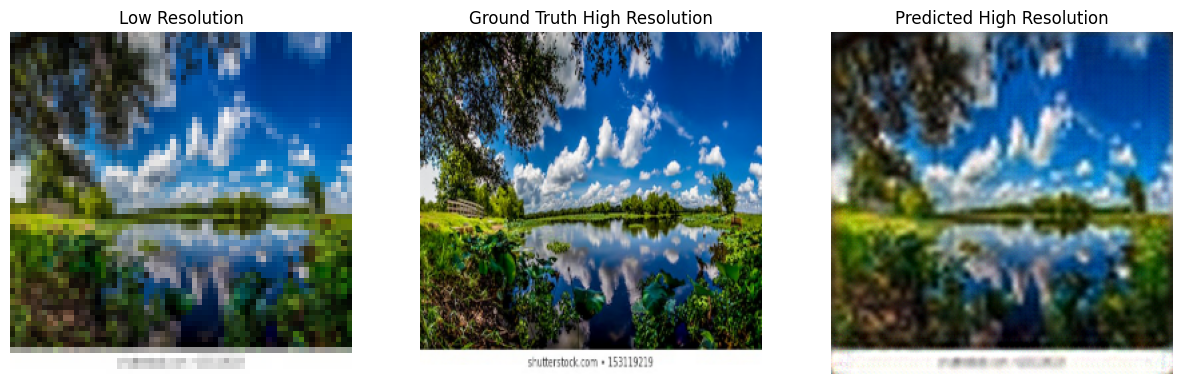

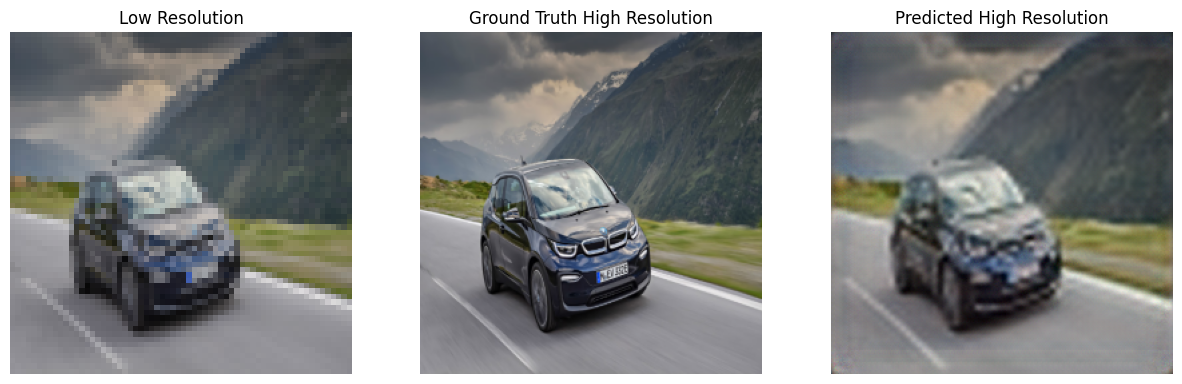

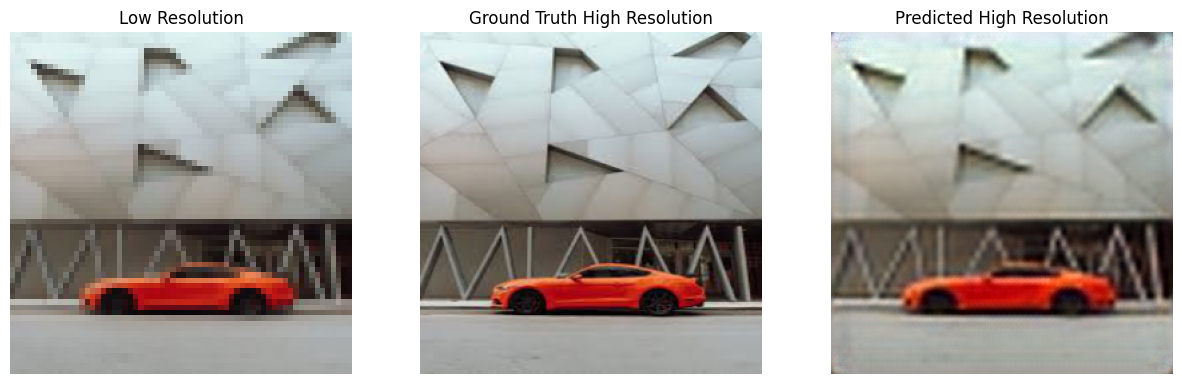

In [12]:
# load the model so that you don't need to train the model again
test_model = torch.load("model.pth").to(device)

# Set the model to evaluation mode
test_model.eval()
total_test_psnr = 0.0

# Run the model to get the reconstructed high-resolution images
with torch.no_grad():
  for test_batch in test_loader:
    # Move the low-res and high-res images to the same device as the model
    low_img = test_batch['low_img'].to(device)
    high_img = test_batch['high_img'].to(device)
    predicted_img = test_model(low_img)
    # Calculate PSNR for the current batch and accumulate the results
    psnr_value = calculate_psnr(predicted_img, high_img)
    total_test_psnr += psnr_value

test_psnr = total_test_psnr / len(test_loader)
print(f"PSNR for the testing data: {test_psnr:.2f} dB")

# Convert the tensors back to numpy arrays for visualization
high_img_np = high_img.cpu().permute(0, 2, 3, 1).numpy()  # (batch_size, height, width, channels)
low_img_np = low_img.cpu().permute(0, 2, 3, 1).numpy()    # (batch_size, height, width, channels)
predicted_img_np = predicted_img.cpu().permute(0, 2, 3, 1).numpy()  # (batch_size, height, width, channels)

# Plot some sample results
num_samples = 3  # Adjust this to show more/less samples
for i in range(num_samples):
    plt.figure(figsize=(15, 5))

    # Low resolution image
    plt.subplot(1, 3, 1)
    plt.imshow(low_img_np[i])
    plt.title('Low Resolution')
    plt.axis('off')

    # Ground truth high resolution image
    plt.subplot(1, 3, 2)
    plt.imshow(high_img_np[i])
    plt.title('Ground Truth High Resolution')
    plt.axis('off')

    # Predicted high resolution image
    plt.subplot(1, 3, 3)
    plt.imshow(predicted_img_np[i])
    plt.title('Predicted High Resolution')
    plt.axis('off')

    plt.show()